### Question 4 [10 points]

Reproduce Figure 1 in the paper. When doing that, try to slice data using `xarray` in the most clear and reproducible way (for example, don't use indices to access data objects like we did in the example above).

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec
import matplotlib.pyplot as plt
import numpy as np

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")

In [2]:
ds['analysed_sst'] = ds['analysed_sst'] - 273.15
sel_data = ds.sel(time = slice("2002", "2012"))
month_mean = sel_data.analysed_sst.groupby(sel_data.time.dt.month).mean(dim='time')
month_std = sel_data.analysed_sst.groupby(sel_data.time.dt.month).std(dim='time')

In [3]:
year_2014 = ds.sel(time = "2014")
year_2015 = ds.sel(time = "2015")
year_2016 = ds.sel(time = "2016")

group_2014 = year_2014.analysed_sst.groupby(year_2014.time.dt.month).mean(dim='time')
group_2015 = year_2015.analysed_sst.groupby(year_2015.time.dt.month).mean(dim='time')
group_2016 = year_2016.analysed_sst.groupby(year_2016.time.dt.month).mean(dim='time')

In [4]:
anom_2014 = group_2014 - month_mean

In [5]:
anom_2015 = group_2015 - month_mean

In [6]:
anom_2016 = group_2016 - month_mean

In [7]:
anom_2014 = anom_2014.where(abs(anom_2014) >= month_std)
anom_2015 = anom_2015.where(abs(anom_2015) >= month_std)
anom_2016 = anom_2016.where(abs(anom_2016) >= month_std)

In [8]:
anoms = [anom_2014, anom_2015, anom_2016]

In [9]:
from matplotlib import colors

custom_colormap = colors.LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:001050-17:0350AF-33.3:00FFEC-47:FFFFFF-50:FFFFFF-53.2:FFFFFF-66.6:FFF600-83:FF5100-100:750005
    (0.000, (0.000, 0.063, 0.314)),
    (0.170, (0.012, 0.314, 0.686)),
    (0.333, (0.000, 1.000, 0.925)),
    (0.470, (1.000, 1.000, 1.000)),
    (0.500, (1.000, 1.000, 1.000)),
    (0.532, (1.000, 1.000, 1.000)),
    (0.666, (1.000, 0.965, 0.000)),
    (0.830, (1.000, 0.318, 0.000)),
    (1.000, (0.459, 0.000, 0.020))))

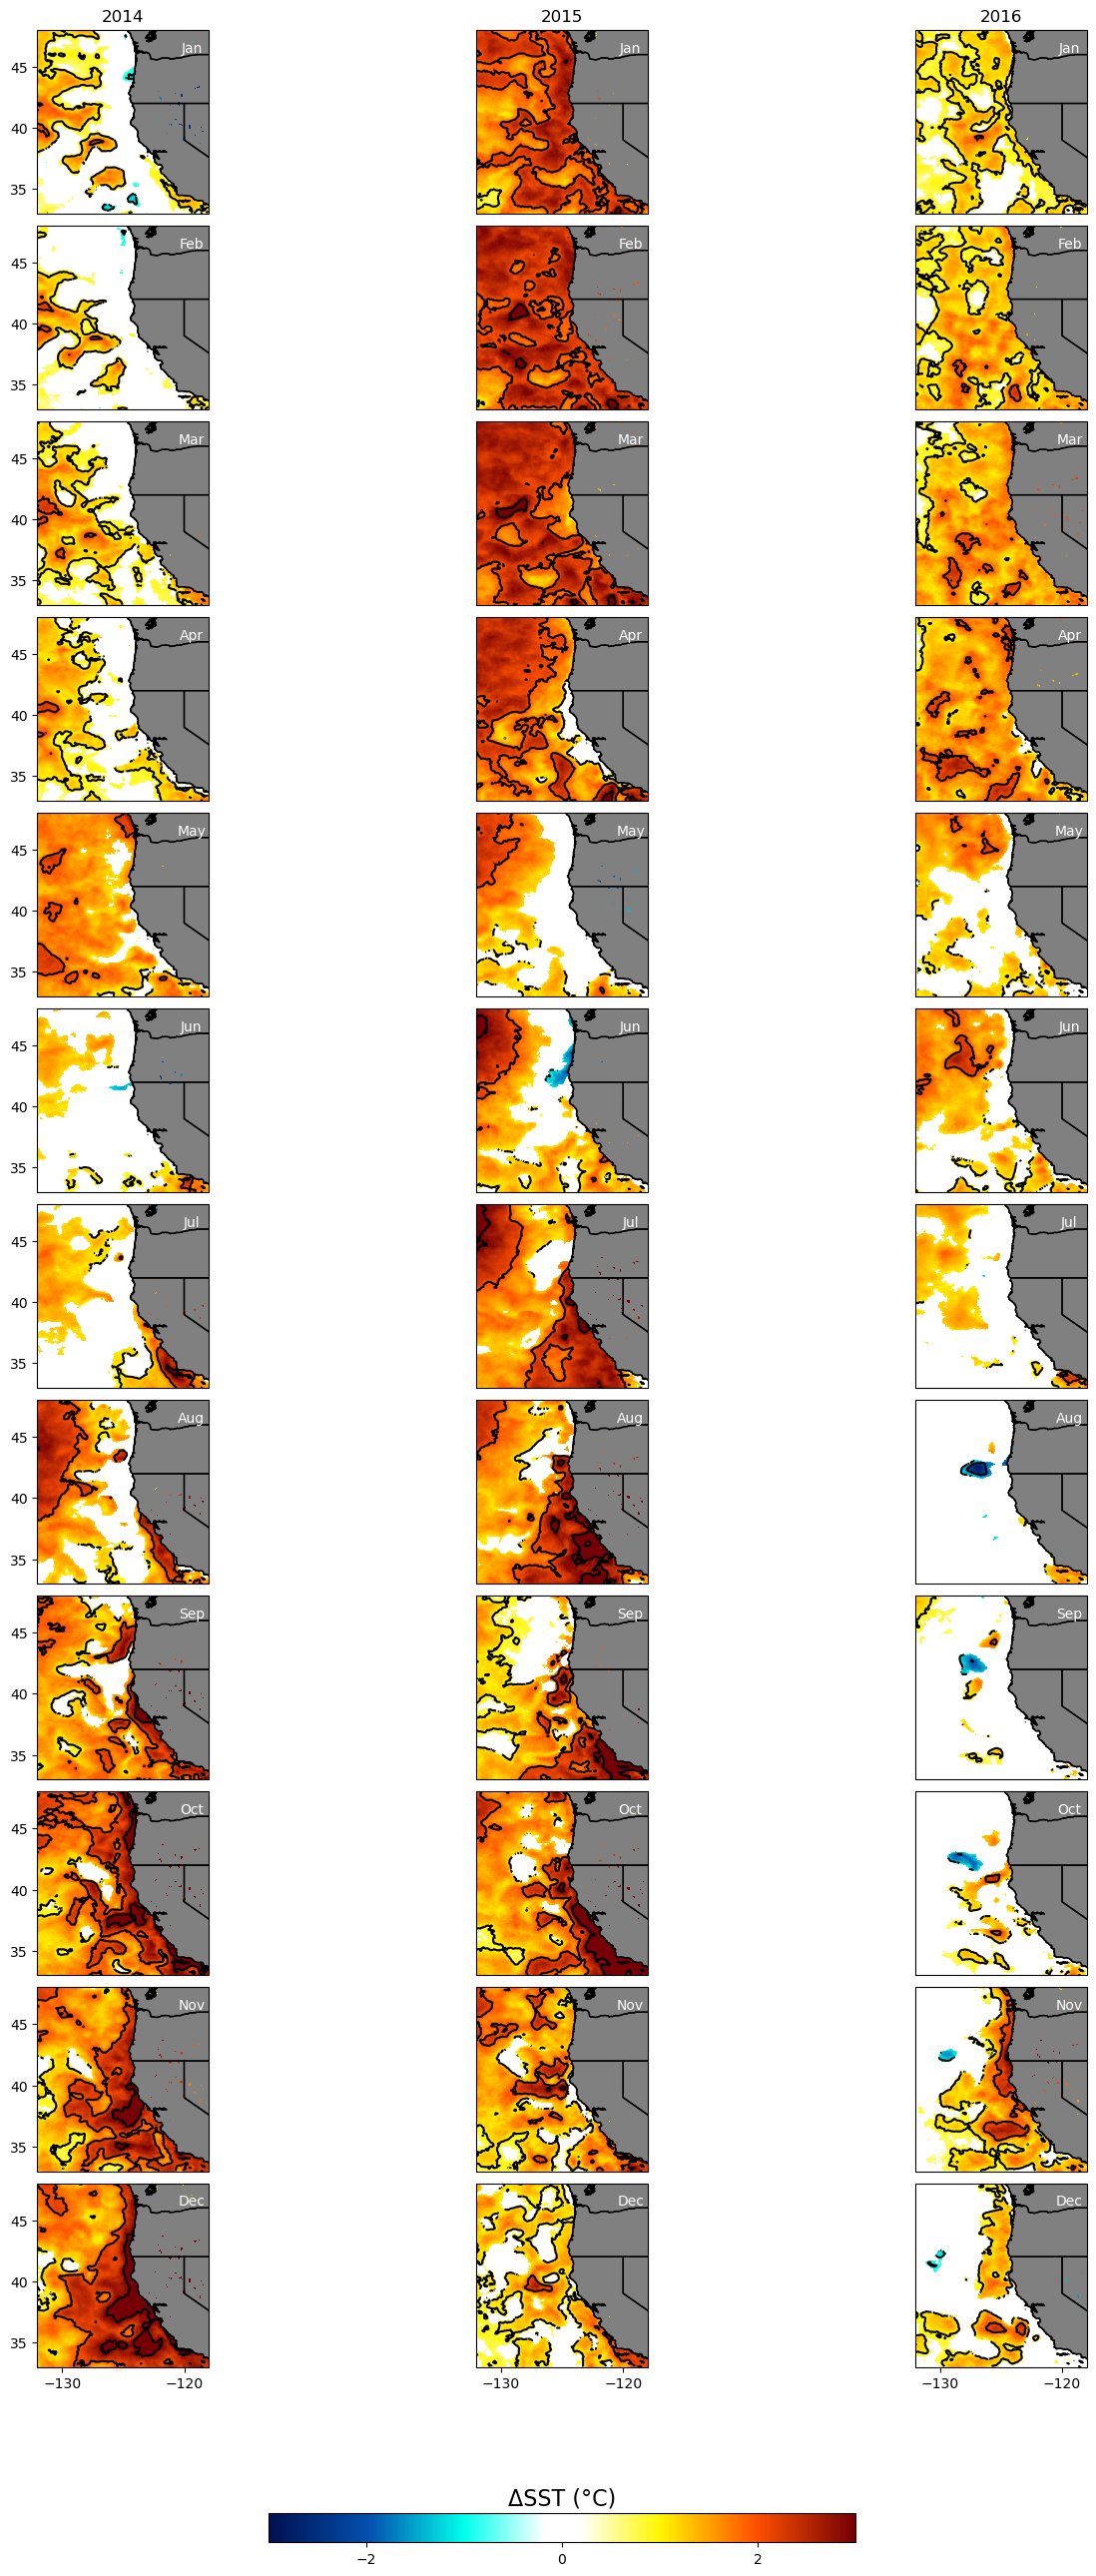

In [10]:
fig, axs = plt.subplots(12, 3, figsize=(15, 30), subplot_kw={'projection': ccrs.PlateCarree()}, sharex=True,sharey=True)

fig.subplots_adjust(wspace=0.2, hspace=0.02)

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
years = ['2014', '2015', '2016']

for i in range(12):
    for j in range(3):
        ax = axs[i, j]
        ax.set_title(f"Plot {(i*3+j)+1}")
        month = anoms[j].sel(month=i+1)
        month.plot(ax=ax, x='lon', y='lat', transform=crs,
                   cmap=custom_colormap, vmin=-3, vmax=3, add_colorbar=False)
        month.plot.contour(ax=ax, transform=crs, colors="black",
                           levels=[-3, -2, -1, 1, 2, 3],
                           linestyles='solid')
        ax.coastlines("10m", color="k")
        ax.add_feature(cfeature.LAND, color="grey")
        ax.add_feature(cfeature.STATES.with_scale("10m"))
        ax.text(.9, .9, months[i], horizontalalignment='center', 
                verticalalignment='center', color='white', transform=ax.transAxes)
        if j == 0:
            ax.set_yticks(np.arange(35, 46, 5))
            
        if i == 11:
            ax.set_xticks(np.arange(-130, -119, 10))
            
        ax.set_xlabel("")
        ax.set_ylabel("")
        
        if i == 0:
            ax.set_title(years[j])
            
        else:
            ax.set_title("")


plt.tight_layout()
norm = plt.Normalize(vmin=-3, vmax=3)
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_colormap), 
             ticks=[-2, 0, 2], orientation="horizontal", ax=axs, pad=0.05, shrink=0.4)
cb.ax.set_title("ΔSST (°C)", size=16)
plt.show()